In [1]:
import numpy as np
import matplotlib.pyplot as plt 

from qcodes import VisaInstrument, InstrumentChannel, ParameterWithSetpoints, ChannelList
from qcodes.utils.validators import Enum, Numbers, Arrays

from qcodes.dataset.database import initialise_database
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id
from qcodes.dataset.experiment_container import new_experiment

In [2]:
def strip_quotes(string): 
    return string.strip('"')

In [3]:
class _TektronixDPOData(InstrumentChannel): 
    """
    This is meant to be a private class, only to be used 
    by the TektronixDPO7000xx driver class. The end user
    is not intended to call parameters on this submodule 
    directly. 
    """
    def __init__(self, parent, name): 
        
        super().__init__(parent, name)
        
        self.add_parameter(
            "start", 
            get_cmd="DATa:STARt?", 
            set_cmd="DATa:STARt {}", 
            get_parser=int
        )
        
        self.add_parameter(
            "stop", 
            get_cmd="DATa:STOP?", 
            set_cmd="DATa:STOP {}", 
            get_parser=int
        )
        
        self.add_parameter(
            "source", 
            get_cmd="DATa:SOU?", 
            set_cmd="DATa:SOU {}", 
            vals=Enum(*[
                f"{name}{i}" 
                for name in TektronixDPOChannel.channel_types
                for i in range(1, 5)
            ])
        )
        
        self.add_parameter(
            "encoding", 
            get_cmd="DATa:ENCdg?",
            set_cmd="DATa:ENCdg {}", 
            get_parser=strip_quotes,
            vals=Enum(
                "ASCIi",
                "FAStest",
                "RIBinary",
                "RPBinary",
                "FPBinary",
                "SRIbinary",
                "SRPbinary",
                "SFPbinary",
            ), 
            docstring="""
            For a detailed explanation of the 
            set arguments, please consult the 
            programmers manual at page 263/264. 
            
            http://download.tek.com/manual/077001022.pdf
            """
        )

In [4]:
class _TektronixDPOWaveformFormat(InstrumentChannel): 
    """
    This class abstracts the waveform formatting data
    and is meant to be strictly private. Instances of 
    this class are coupled to specific channels, because 
    parameter values of this class depend on which 
    channel has been selected. 
    """

    def __init__(self, parent, name): 
        
        super().__init__(parent, name)
        
        
        self.add_parameter(
            "raw_data_offset", 
            get_cmd="WFMOutPRE:YOFF?", 
            get_parser=float,
            docstring="""
            Raw acquisition values range from min to max. 
            For instance, for unsigned binary values of one 
            byte, min=0 and max=255. The data offset specifies 
            the center of this range
            """
        )
        
        self.add_parameter(
            "x_unit", 
            get_cmd="WFMOutpre:XUNit?",
            get_parser=strip_quotes
        )
        
        self.add_parameter(
            "x_increment", 
            get_cmd="WFMOutPRE:XINCR?", 
            unit=self.x_unit(), 
            get_parser=float
        )
        
        self.add_parameter(
            "y_unit", 
            get_cmd="WFMOutpre:YUNit?",
            get_parser=strip_quotes
        )
        
        self.add_parameter(
            "offset", 
            get_cmd="WFMOutPRE:YZERO?", 
            get_parser=float,
            unit=self.y_unit()   
        )
        
        self.add_parameter(
            "scale", 
            get_cmd="WFMOutPRE:YMULT?", 
            get_parser=float,
            unit=self.y_unit()
        )

In [5]:
class TektronixDPOChannel(InstrumentChannel): 
    
    channel_types = {
        "CH": "channel", 
        "MATH": "math", 
        "REF": "reference"
    }
    
    def __init__(self, parent, name, channel_type, channel_number): 
        
        if channel_type not in self.channel_types: 
            acceptable_types = "".join(self.channel_types.keys())
            raise ValueError(
                f"Channel type needs to be one of {acceptable_types}"
            )
        
        super().__init__(parent, name)
        
        self._channel_type = channel_type
        self._channel_number = channel_number
        self._intentifier = f"{channel_type}{channel_number}"
        
        waveform_format = _TektronixDPOWaveformFormat(
            self.parent, "_waveform_format")
        
        self.add_submodule(
            "_waveform_format", 
            waveform_format
        )
        
        self.add_submodule(
            "_data", 
            _TektronixDPOData(self, "_data")
        )
        
        self.add_parameter(
            "scale", 
            get_cmd=f"{self._intentifier}:SCA?", 
            set_cmd=f"{self._intentifier}:SCA {{}}", 
            get_parser=float,
            unit="V/div"
        )
        
        self.add_parameter(
            "offset", 
            get_cmd=f"{self._intentifier}:OFFS?", 
            set_cmd=f"{self._intentifier}:OFFS {{}}", 
            get_parser=float,
            unit="V"
        )
        
        self.add_parameter(
            "position", 
            get_cmd=f"{self._intentifier}:POS?", 
            set_cmd=f"{self._intentifier}:POS {{}}", 
            get_parser=float,
            unit="V"
        )
        
        self.add_parameter(
            "termination", 
            get_cmd=f"{self._intentifier}:TER?", 
            set_cmd=f"{self._intentifier}:TER {{}}",
            vals=Numbers(50, 1E6), 
            get_parser=float,
            unit="Ohm"
        )
        
        self.add_parameter(
            "analog_to_digital_threshold", 
            get_cmd=f"{self._intentifier}:THRESH?", 
            set_cmd=f"{self._intentifier}:THRESH {{}}", 
            get_parser=float,
            unit="V",
        )
        
        self.add_parameter(
            "termination_voltage", 
            get_cmd=f"{self._intentifier}:VTERm:BIAS?", 
            set_cmd=f"{self._intentifier}:VTERm:BIAS {{}}", 
            get_parser=float,
            unit="V"
        )
        
        self.add_parameter(
            "trace_axis",
            label="Time",
            get_cmd=self._get_trace_setpoints,
            vals=Arrays(shape=(self.get_trace_length,)),
            unit=waveform_format.x_unit()
        )
        
        self.add_parameter(
            "trace",
            label="Voltage",
            get_cmd=self._get_trace_data,
            vals=Arrays(shape=(self.get_trace_length,)),
            unit=waveform_format.y_unit(), 
            setpoints=(self.trace_axis,),
            parameter_class=ParameterWithSetpoints
        )
        
    def _get_trace_data(self): 
        
        self._data.source(self._intentifier)
        self._data.encoding("RPBinary")
        
        scale = self._waveform_format.scale()
        offset = self._waveform_format.offset()
        raw_data_offset = self._waveform_format.raw_data_offset()
        
        raw_data = self.parent.visa_handle.query_binary_values(
            'CURVE?', 
            datatype='B'
        )
        
        return (np.array(raw_data) - raw_data_offset) * scale  + offset
    
    def _get_trace_setpoints(self): 
        
        sample_count = self.get_trace_length()
        sample_rate = self.parent.horizontal.sample_rate()
        
        return np.linspace(0, sample_count / sample_rate, sample_count)
    
    def get_trace_length(self): 
        return self._data.stop() - self._data.start() + 1
    
    def set_trace_length(self, value): 
        if self.parent.horizontal.record_length() < value: 
            raise ValueError(
                "Cannot set a trace length which is larger than "
                "the record length. Please switch to manual mode "
                "and adjust the record length first"
            )
            
        self._data.start(1)
        self._data.stop(value)
    
    def set_trace_time(self, value): 
        
        sample_rate = self.parent.horizontal.sample_rate()
        required_sample_count = sample_rate * value
        self.set_trace_length(required_sample_count)

In [6]:
class ModeError(Exception): 
    pass 

In [7]:
class TektronixDPOHorizontal(InstrumentChannel): 
    """
    This module controls the horizontal axis of the scope
    """
    
    def __init__(self, name, parent): 
        super().__init__(name, parent)
        
        self.add_parameter(
            "mode", 
            get_cmd="HORizontal:MODE?",
            set_cmd="HORizontal:MODE {}", 
            vals=Enum("auto", "constant", "manual"), 
            get_parser=str.lower,
            docstring="""
            Auto mode attempts to keep record length 
            constant as you change the time per division 
            setting. Record length is read only.
            
            Constant mode attempts to keep sample rate 
            constant as you change the time per division 
            setting. Record length is read only.
            
            Manual mode lets you change sample mode and 
            record length. Time per division or Horizontal 
            scale is read only.
            """
        )
        
        self.add_parameter(
            "unit", 
            get_cmd="HORizontal:MAIn:UNIts?", 
            get_parser=strip_quotes
        )
        
        self.add_parameter(
            "record_length", 
            get_cmd="HORizontal:MODE:RECOrdlength?", 
            set_cmd=self._set_record_length, 
            get_parser=float
        )
        
        self.add_parameter(
            "sample_rate", 
            get_cmd="HORizontal:MODE:SAMPLERate?", 
            set_cmd="HORizontal:MODE:SAMPLERate {}", 
            get_parser=float, 
            unit=f"sample/{self.unit()}"
        )
        
        self.add_parameter(
            "scale", 
            get_cmd="HORizontal:MODE:SCAle?", 
            set_cmd=self._set_scale,
            get_parser=float, 
            unit=f"{self.unit()}/div"
        )
        
        self.add_parameter(
            "position", 
            get_cmd="HORizontal:POSition?", 
            set_cmd="HORizontal:POSition {}",
            get_parser=float, 
            unit="%", 
            docstring="""
            The horizontal position relative to a 
            recieved trigger. E.g. a value of '10'
            sets the trigger position of the waveform 
            such that 10% of the display is to the 
            left of the trigger position.
            """
        )
        
        self.add_parameter(
            "roll", 
            get_cmd="HORizontal:ROLL?", 
            set_cmd="HORizontal:ROLL {}",
            vals=Enum("Auto", "On", "Off"), 
            docstring="""
            Use Roll Mode when you want to view data at 
            very slow sweep speeds.
            """
        )
    
    def _set_record_length(self, value): 
        if self.mode() != "manual": 
            raise ModeError(
                "The record length can only be changed in manual mode"
            )
        self.write(f"HORizontal:MODE:RECOrdlength {value}")
    
    def _set_scale(self, value): 
        if self.mode() == "manual": 
            raise ModeError(
                "The scale cannot be changed in manual mode"
            )
        
        self.write(f"HORizontal:MODE:SCAle {value}")

In [8]:
class TektronixDPO7000xx(VisaInstrument): 
    """
    QCoDeS driver for the MSO/DPO5000/B, DPO7000/C, 
    DPO70000/B/C/D/DX/SX, DSA70000/B/C/D, and 
    MSO70000/C/DX Series Digital Oscilloscopes
    """
    
    def __init__(self, name, address, **kwargs): 
        
        super().__init__(name, address, terminator="\n", **kwargs)
        
        self.add_submodule(
            "horizontal", 
            TektronixDPOHorizontal(self, "horizontal")
        )
        
        channel_types = TektronixDPOChannel.channel_types.items()
        for channel_type, friendly_name in channel_types: 
            
            channel_list = ChannelList(self, friendly_name, TektronixDPOChannel)
            for channel_number in range(1, 5):
                
                name = f"{channel_type}{channel_number}"
                submod = TektronixDPOChannel(self, name, channel_type, channel_number)
                self.add_submodule(name, submod)
                channel_list.append(submod)
        
            self.add_submodule(friendly_name, channel_list)
        
        self.connect_message()

In [9]:
tek = TektronixDPO7000xx("tek3", "TCPIP0::10.193.36.56::inst0::INSTR")

Connected to: TEKTRONIX DPO72004C (serial:C600651, firmware:CF:91.1CT FV:10.8.3 Build 3) in 0.56s


In [10]:
initialise_database()
experiment = new_experiment(name='DPO_72000_example', sample_name="no sample")

In [13]:
tek.channel[0].set_trace_time(2E-3)

Starting experimental run with id: 64


([<matplotlib.axes._subplots.AxesSubplot at 0x1cbe2cc2ba8>], [None])

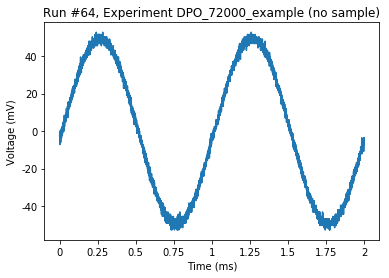

In [14]:
meas = Measurement(exp=experiment)
meas.register_parameter(tek.channel[0].trace)

with meas.run() as datasaver:
    datasaver.add_result(
        (tek.channel[0].trace_axis, tek.channel[0].trace_axis()),
        (tek.channel[0].trace, tek.channel[0].trace())
    )

    dataid = datasaver.run_id

plot_by_id(dataid)